### Rafael Augusto Gaseta França - 1421436
### Pedro Ferreira Alves Pinto - 1320981

### Sobre o DataSet

Existe uma api do proprio kaggle para download de seus datasets, entretanto é preciso configuracao de credencial, o que nao seria viavel dentro de um notebook.Por favor, faça o download do dataset e extraia na pasta do projeto.

# https://www.kaggle.com/rounakbanik/the-movies-dataset/data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import re
import math

%matplotlib inline

In [2]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

### Funções gerais

In [3]:
def apply_money_clear( cell ):
    if cell == "" or cell == "False" or cell == "false":
        return 0
    else:
        return cell

In [4]:
def apply_data( cell ):
    if cell == None:
        return np.NaN
        
    if type(cell) != str:
        return np.NaN
    
    if re.search('\d{4}-\d{2}-\d{2}', cell ) == None:
        return np.NaN
    
    return cell

In [5]:
def apply_toLog( value ):
    if value < 10:
        value = 10
    return math.log10( value )

In [6]:
def style_highlight_max(s):
    is_max = s == s.max()
    return ['background-color: #81ff77' if v else '' for v in is_max]

def style_highlight_min(s):
    is_min = s == s.min()
    return ['background-color: #ffc97b' if v else '' for v in is_min]

def style_highlight_min_max(s):
    minList = style_highlight_min( s )
    maxList = style_highlight_max( s )
    
    minMaxList = ['' for _ in range(len(maxList)) ]
    
    for i in range(len(minMaxList)):
        if maxList[i] == '':
            if minList[i] != '':
                # Eh Minimo
                minMaxList[i] = 'background-color: #ffc97b'
                
        else:
            # Eh Maximo
            minMaxList[i] = 'background-color: #81ff77'

    return minMaxList 

# Carga e Tratamento inicial dos dados

In [7]:
def convert_clearJSONString( jsonString ):
    jsonString = jsonString.replace("\\", "\\\\")
    jsonString = jsonString.replace("\"", "\'")
    jsonString = re.sub( r"({ *)'" , r'\1"' ,  jsonString )
    jsonString = re.sub( r"'( *})" , r'"\1' ,  jsonString )
    jsonString = re.sub( r"'( *[:,] *)'" , r'"\1"' ,  jsonString )
    jsonString = re.sub( r"'( *: *\d+)" , r'"\1' ,  jsonString )
    jsonString = re.sub( r"(\d+ *, *)'" , r'\1"' ,  jsonString )
    jsonObj = json.loads(jsonString)
    return jsonObj

def apply_filter_validJSON_list( value ):      
    if value == None or type(value) != str or re.search('^\[.*\]$', value ) == None:
        return json.loads("[]")
    else:
        value = convert_clearJSONString( value )
        return value
    
def apply_filter_language( value ):
    if value == None:
        return "unknown"
    
    elif type(value) != str:
        return "unknown"
    
    try: 
        float(value)
        return "unknown"
    except ValueError:
        return value
    
def apply_filter_countryList( value ):
    if value == None:
        return None
    
    elif type(value) != str:
        return None
    
    elif re.search('^\[.*\]$', value ) != None:
        dictList = convert_clearJSONString( value )
        countryList = list()
        
        for countryDict in dictList:
            for key , value in countryDict.items():
                if key == 'iso_3166_1':
                    countryList.append( value )
                                
        return countryList
        
    else:
        return None
    

In [8]:
df_movies_metadata = pd.read_csv('movies_metadata.csv' , low_memory=False ).drop_duplicates()

In [9]:
# Processando o JSON da coluna genres
df_movies_metadata['genres'] = df_movies_metadata['genres'].apply( apply_filter_validJSON_list )

# Processando o JSON da coluna production_companies
df_movies_metadata['production_companies'] = df_movies_metadata['production_companies'].apply( apply_filter_validJSON_list )

# Processando a coluna original_language
df_movies_metadata['original_language'] = df_movies_metadata['original_language'].apply( apply_filter_language )

# Processando o JSON na coluna  production_countries
df_movies_metadata['production_countries'] = df_movies_metadata['production_countries'].apply( apply_filter_countryList )

# Clean budget and revenue columns and create profit column
df_movies_metadata['budget'] = df_movies_metadata['budget'].apply(apply_money_clear)
df_movies_metadata['budget'] = df_movies_metadata['budget'].apply(pd.to_numeric , errors='coerce').fillna(0)

df_movies_metadata['revenue'] = df_movies_metadata['revenue'].apply(apply_money_clear )
df_movies_metadata['revenue'] = df_movies_metadata['revenue'].apply(pd.to_numeric , errors='coerce').fillna(0)

df_movies_metadata['profit'] = df_movies_metadata['revenue'] - df_movies_metadata['budget']

# Convertendo String em Data
df_movies_metadata['release_date'] = df_movies_metadata['release_date'].apply( apply_data )
df_movies_metadata['release_date'] = pd.to_datetime( df_movies_metadata['release_date'] )



In [10]:
df_movies_metadata

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,profit
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,343554033.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,197797249.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,0.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,65452156.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,76578911.0
5,False,NaN,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0,127436818.0
6,False,NaN,58000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,...,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0,-58000000.0
7,False,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,45325,tt0112302,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",...,0.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Original Bad Boys.,Tom and Huck,False,5.4,45.0,0.0
8,False,NaN,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0,29350171.0
9,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,...,352194034.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0,294194034.0


In [11]:
def generateGenreDataFrame( movies_dataframe , fullInfo = True , yearWindow = 1, yearOffset = 0 ):
    profitByGenreData = list()

    for index, row in movies_dataframe.iterrows():
        naRow = row.isna()

        if row['budget'] < 1:
            continue

        if row['revenue'] < 1:
            continue

        if naRow['release_date'] == True:
            continue

        # Dados a coletar
        profit = row['profit']
        title = row['title']
        releaseDate = row['release_date']

        for genre in row['genres']:
            genreName = genre.get("name")
            if genreName != None:
                dataDict = dict()
                if fullInfo == True:
                    dataDict['title'] = title
                    dataDict['original_language'] = row['original_language']
                    
                # Info needed for group operations
                dataDict['genre'] = genreName
                dataDict['profit'] = profit
                dataDict['year'] = ( int( (releaseDate.year - yearOffset ) / yearWindow ) * yearWindow ) + yearOffset
                profitByGenreData.append( dataDict )

    # build dataframe
    genreDataFrame = pd.DataFrame(profitByGenreData)
    genreDataFrame.fillna( 0 , inplace = True )  
    
    return genreDataFrame
    

# Clustering

Na parte descritiva, separamos quantos filmes por cada genero foi lançado por cada idioma.
Fizemos um radar chart para representar o perfil de cada idioma ( vamos replicar abaixo ).

Vamos agora tentar entender se existe a possibilidade de agrupar esses perfis.

In [12]:
df_genre_movie_info = generateGenreDataFrame( df_movies_metadata )

# Criando Pivot Table
df_genre_movie_info_grouped = df_genre_movie_info.groupby(  ['genre','original_language'] ).size().reset_index()
df_genre_movie_info_grouped.columns = ['genre','language','count']
df_genre_movie_info_grouped

pivot_genre_movie_info = df_genre_movie_info_grouped.pivot(index='language', columns='genre', values='count' )

# Trocando NaN por 0
pivot_genre_movie_info.fillna(0, inplace=True)

In [13]:
# Abreviando as etiquetas para os plots
abrvLabels = list()
desiredLabelLen = 3
for label in list(pivot_genre_movie_info.columns):
    lastPos = min(desiredLabelLen,len(label))
    abrvLabel = label[0:lastPos]
    if len(label) > desiredLabelLen:
        abrvLabel += "."

    abrvLabels.append(abrvLabel)
    print( abrvLabel + " > " + label )


Act. > Action
Adv. > Adventure
Ani. > Animation
Com. > Comedy
Cri. > Crime
Doc. > Documentary
Dra. > Drama
Fam. > Family
Fan. > Fantasy
For. > Foreign
His. > History
Hor. > Horror
Mus. > Music
Mys. > Mystery
Rom. > Romance
Sci. > Science Fiction
TV . > TV Movie
Thr. > Thriller
War > War
Wes. > Western


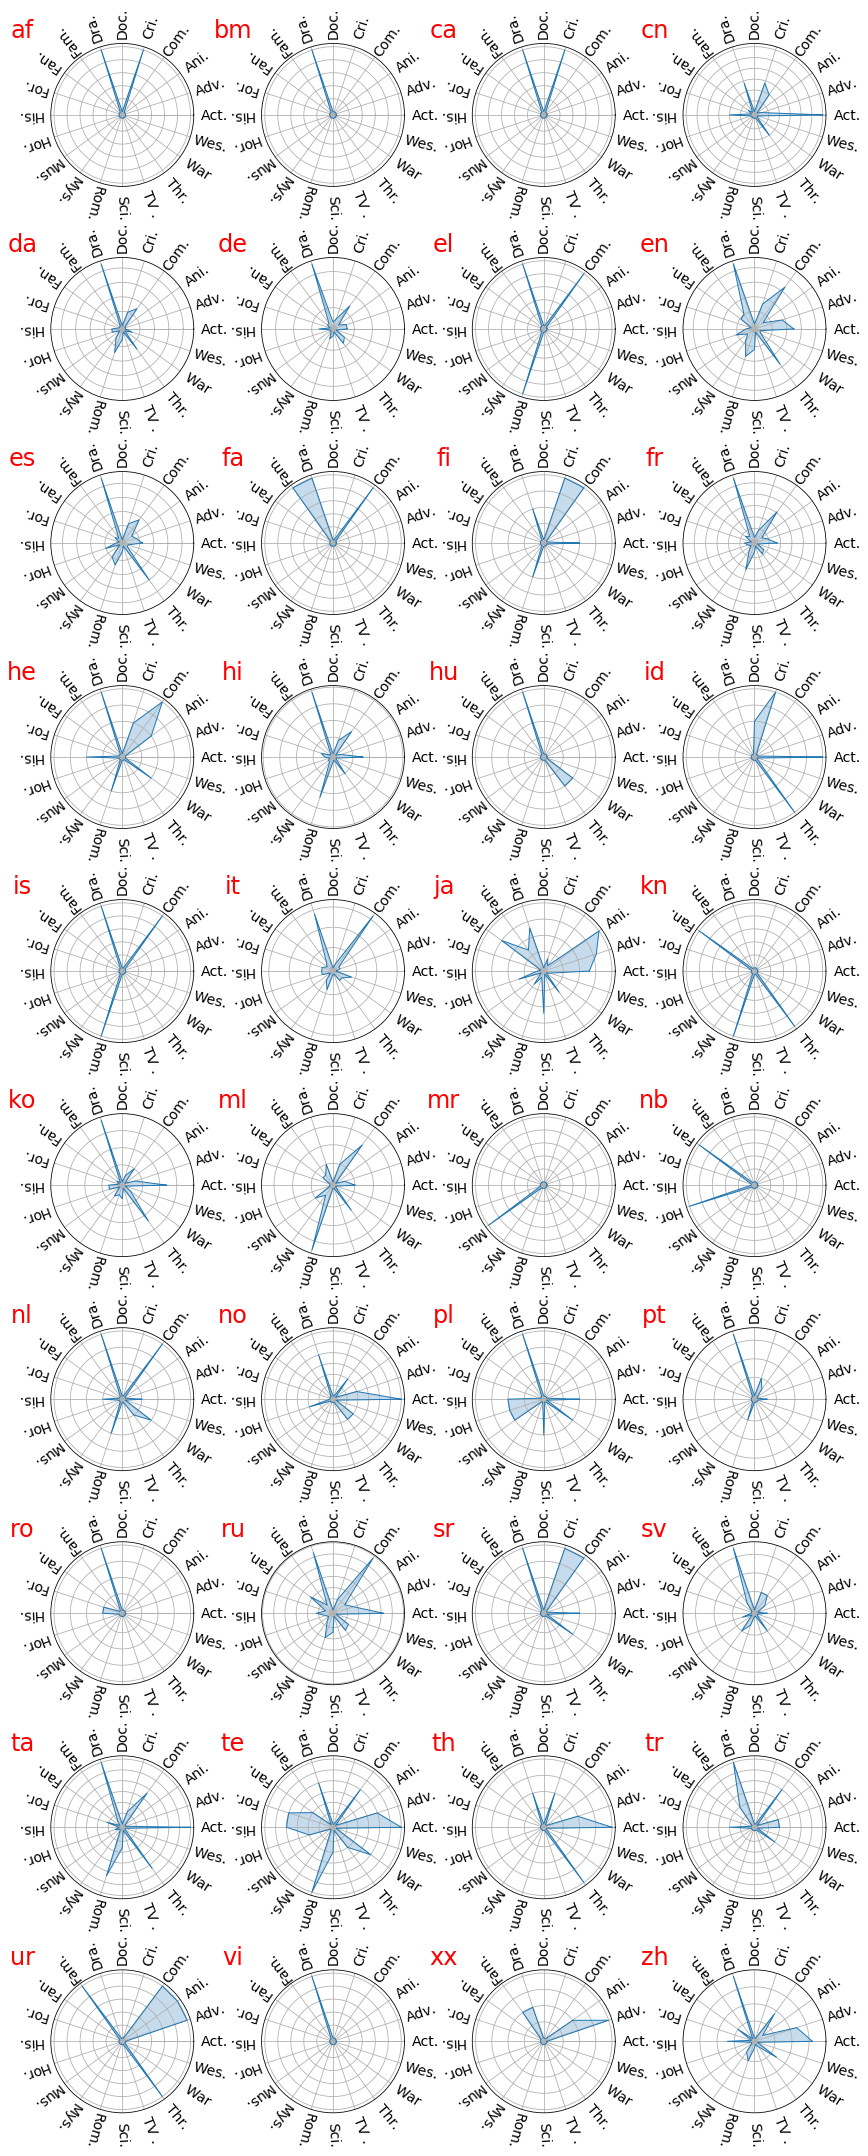

In [14]:
# Graph Data
plots = len(pivot_genre_movie_info.index)

cols = 4
rows = int(plots/cols) + 1

fig = plt.figure(figsize=(cols*3,rows*3))

for i in range( plots ):
    labels=np.array( abrvLabels )
    stats=pivot_genre_movie_info.iloc[i].values
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    
    # close the plot
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))

    # Plot
    ax = plt.subplot(rows ,cols , i+1, polar=True)

    ax.plot(angles, stats, 'o-', linewidth=1, markersize = 0 )
    ax.fill(angles, stats, alpha=0.25)

    ax.set_thetagrids(angles * 180/np.pi, labels)

    ax.set_title(pivot_genre_movie_info.index[i] , fontsize = 24, color="red" )
    ax.title.set_position([-0.2, 1])

    ax.set_yticklabels([])

    # Arrumando as etiquetas
    labels = []
    for label, angle in zip(ax.get_xticklabels(), angles):
        x,y = label.get_position()
        x = angle
        y = y - 0.1
        lab = ax.text(x,y, label.get_text(), 
                      transform=label.get_transform(),
                      ha= label.get_ha(),
                      va= label.get_va(),
                      fontsize = 14,
                     )
        lab.set_rotation(angle * 58)
        labels.append(lab)

    ax.set_xticklabels([])

    ax.grid(True)

fig.tight_layout( pad=2.5 )

### Observação

Chegamos até este ponto com a análise descritiva

In [15]:
# KMeans
np.random.seed(1101101)

def eval_k_means(estimator, name, data, k):
    t0 = time()
    estimator.fit(data)
    print('%-10s, k=%d: sil=%0.4f' % (name, k, metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

#data = scale(pivot_genre_movie_info)
data = StandardScaler().fit_transform(pivot_genre_movie_info)

sample_size=150
best_sil = -999

min_clusters = 5
max_clusters = 10

for init in ['k-means++', 'random']:
    for k in range(min_clusters,max_clusters):
        estimator = KMeans(init=init, n_clusters=k, n_init=10, max_iter=100)
        estimator.fit(data)
        sil = metrics.silhouette_score(data, estimator.labels_,
                                          metric='euclidean',
                                          sample_size=sample_size)
        print('%-10s, k=%d: sil=%0.4f' % (init, k, sil))
        if sil > best_sil:
            best_estimator = estimator
            best_sil = sil

print('better estimator silhouette: %0.4f (%d clusters, %s)' % (best_sil, best_estimator.n_clusters, best_estimator.init))
pivot_genre_movie_info['label'] = best_estimator.labels_

k-means++ , k=5: sil=0.6475
k-means++ , k=6: sil=0.6422
k-means++ , k=7: sil=0.6075
k-means++ , k=8: sil=0.6020
k-means++ , k=9: sil=0.5958
random    , k=5: sil=0.6475
random    , k=6: sil=0.5958
random    , k=7: sil=0.5796
random    , k=8: sil=0.4808
random    , k=9: sil=0.1524
better estimator silhouette: 0.6475 (5 clusters, random)


### Verificação
Vamos verificar quais idiomas foram clusterizados juntos

In [16]:
tempDF = pivot_genre_movie_info[ ['label'] ].copy()
tempDF = tempDF.sort_values( by="label")
tempDF

genre,label
language,
af,0
ml,0
mr,0
nb,0
nl,0
no,0
pl,0
ko,0
pt,0


### Verificação
Verificando quantos elementos/idiomas por cluster

In [17]:
tempDF = pivot_genre_movie_info[ ['label'] ].copy()
tempDF = tempDF.groupby(  ['label'] ).size().reset_index()
tempDF.columns = ['label','qty']
tempDF

,label,qty
0,0,31
1,1,3
2,2,1
3,3,4
4,4,1


Text(0,0.5,'Qtd. de Idiomas')

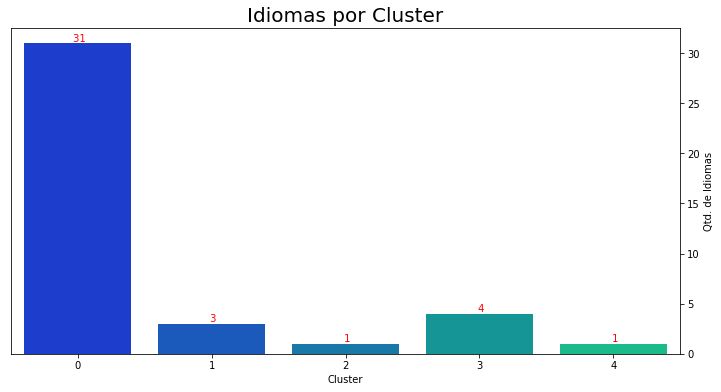

In [18]:
# Plotando resultados
subDim = (2,5)
fig, ax = plt.subplots( figsize=(12, 6) )

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# Etiquetas individuais
for i, v in enumerate( tempDF.label ):
    ax.text( i,
            tempDF.iloc[i]["qty"], 
            " {:.0f}".format(tempDF.iloc[i]["qty"]), 
            color='red', 
            fontweight='regular',
            va='bottom',
            ha='center',
            )

# Plota as Barras
sns.barplot(
    y="qty",
    x="label",
    data=tempDF,
    palette= "winter",
    ax=ax)

# Etiquetas
plt.title("Idiomas por Cluster" , fontsize=20)
plt.xlabel("Cluster")
plt.ylabel("Qtd. de Idiomas" )


### Observação

Apenas 1 cluster contem a maioria dos idiomas, e clusters com apenas 1 elemento. Mesmo a quantidade total de idiomas sendo baixa ( menos de 50 ) vamos investigar melhor esses clusters.

In [19]:
# Utilizando PCA para ajudar na visualização dos clusters
cluster_genre_movie_info = pivot_genre_movie_info.reset_index()

cols = list(cluster_genre_movie_info.columns)
result_cols = ['label','language']
for result_col in result_cols:
    cols.remove( result_col )

x = cluster_genre_movie_info.loc[:, cols].values
x = StandardScaler().fit_transform(x)

y = cluster_genre_movie_info.loc[:,result_cols].values

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

print("Informação coberta pelos componentes PCA: ")
total = 0
for i , varianceRatio in enumerate(pca.explained_variance_ratio_):
    print( str(i+1) + ": " +str(" {:.3f}".format(varianceRatio) ) )
    total += varianceRatio
print( "Total: " +str(" {:.3f}".format(total) ) )


Informação coberta pelos componentes PCA: 
1:  0.975
2:  0.024
Total:  0.999


### Observação
Apenas 1 componente já cobre 97% dos dados

In [20]:
# Montando o DataFrame com os resultados do PCA e os Labels do KMeans
df_genre_movie_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
df_genre_movie_pca = pd.concat([df_genre_movie_pca, cluster_genre_movie_info[result_cols]], axis = 1)
df_genre_movie_pca.head()

,principal component 1,principal component 2,label,language
0,-0.814379,-0.192740,0,af
1,-0.816220,-0.192518,0,bm
2,-0.814379,-0.192740,0,ca
3,-0.728660,-0.200403,0,cn
4,-0.762608,-0.199618,0,da


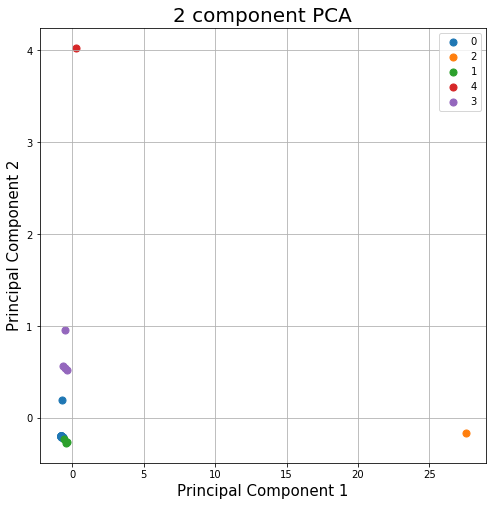

In [21]:
# Plotando os resultados
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = list( df_genre_movie_pca['label'].unique() )
for target in targets:
    indicesToKeep = df_genre_movie_pca['label'] == target
    ax.scatter(df_genre_movie_pca.loc[indicesToKeep, 'principal component 1']
               , df_genre_movie_pca.loc[indicesToKeep, 'principal component 2']
               , s = 50)
ax.legend(targets)
ax.grid()

### Observação

Pelo PCA, os Clusters aparentemente estão bem distintos. Mesmo com a proximidade entre os clusters 0 e 4

### Pair Plots

Devido a quantidade de atributos, a analise dos pair plots pode ser complicada.
Vamos plotar algumas apenas por verificação

In [22]:
cols = list(pivot_genre_movie_info.columns)

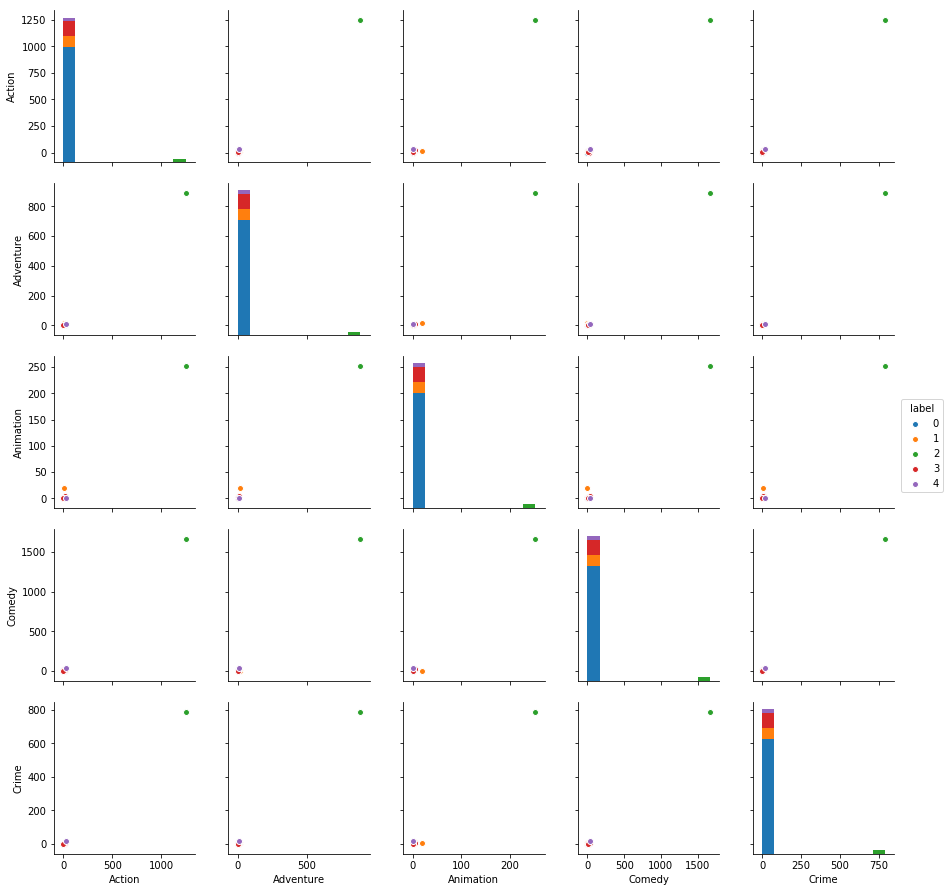

In [23]:
colsToPlot = cols[0:5]
sns.pairplot(data=pivot_genre_movie_info, vars=colsToPlot, hue='label')
plt.show()

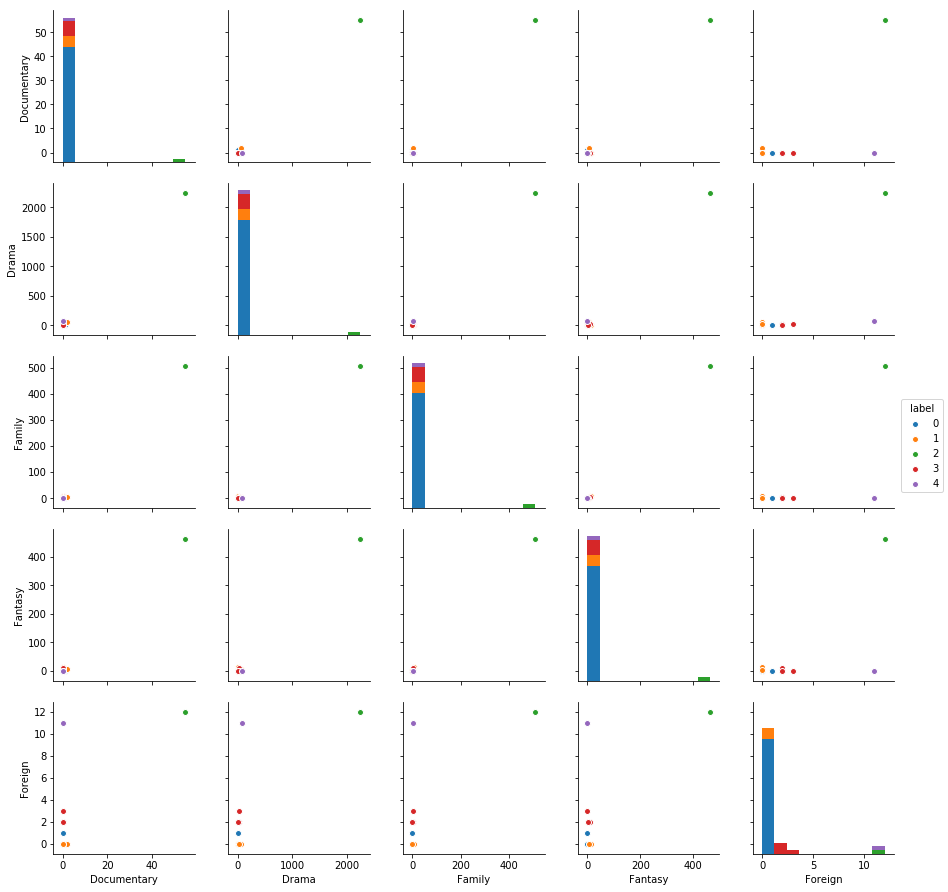

In [24]:
colsToPlot = cols[5:10]
sns.pairplot(data=pivot_genre_movie_info, vars=colsToPlot, hue='label')
plt.show()

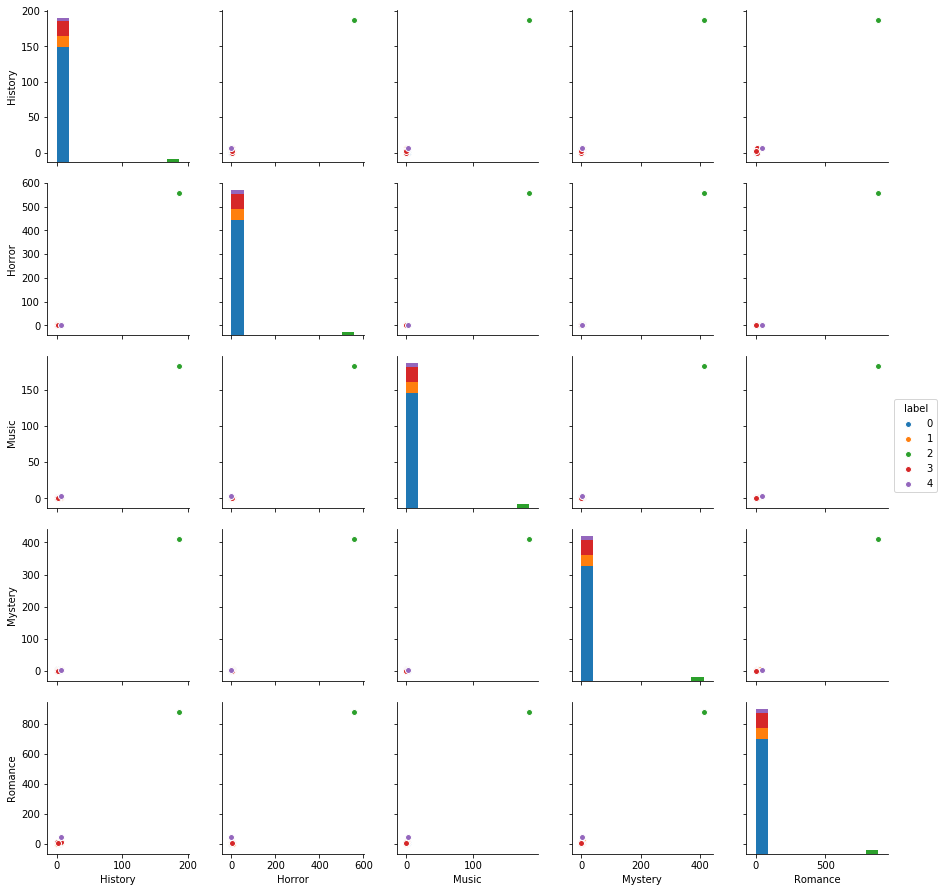

In [25]:
colsToPlot = cols[10:15]
sns.pairplot(data=pivot_genre_movie_info, vars=colsToPlot, hue='label')
plt.show()

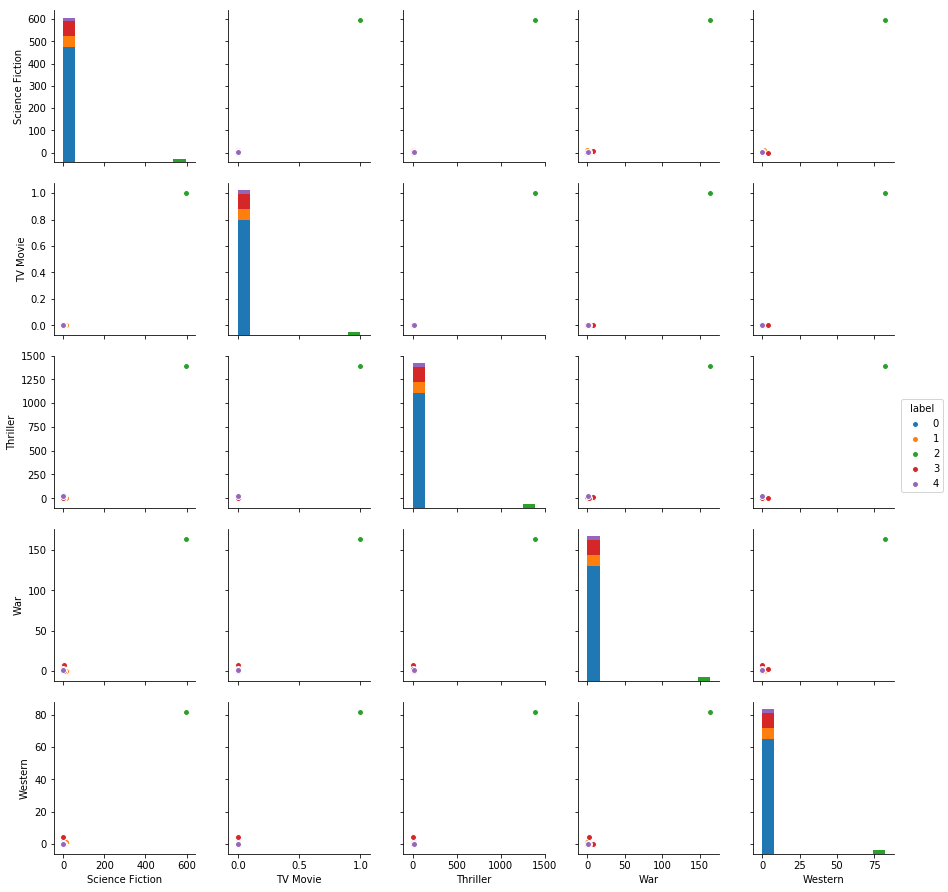

In [26]:
colsToPlot = cols[15:20]
sns.pairplot(data=pivot_genre_movie_info, vars=colsToPlot, hue='label')
plt.show()